### Imports

In [1]:
%cd ..

/home/ds/DataScience/home/ademyanchuk/Projects/ulmfit-multilingual


In [2]:
!pwd

/home/ds/DataScience/home/ademyanchuk/Projects/ulmfit-multilingual


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.text import *

In [5]:
from ulmfit.pretrain_lm import *

In [6]:
cuda_id = 1
torch.cuda.set_device(cuda_id)

### Preparing data

In [7]:
# batch size
bs = 30

In [8]:
# use data from smaller sample of wiki
# data is recieved through prepare_wiki.sh script
wiki_data_path = Path('data/wiki/ru-100-unk/')

In [9]:
wiki_data_path.ls()

[PosixPath('data/wiki/ru-100-unk/ru.wiki.test.tokens'),
 PosixPath('data/wiki/ru-100-unk/ru.wiki.valid.tokens'),
 PosixPath('data/wiki/ru-100-unk/ru.wiki.train.tokens'),
 PosixPath('data/wiki/ru-100-unk/models'),
 PosixPath('data/wiki/ru-100-unk/tmp_lm'),
 PosixPath('data/wiki/ru-100-unk/ru.wiki.train.tokens.temp')]

In [11]:
# provide train and valid path
trn_path = wiki_data_path/'ru.wiki.train.tokens'
val_path = wiki_data_path/'ru.wiki.valid.tokens'

In [12]:
# create a databunch object from data_frames
# data_frames are provided through `read_wiki_articles` function
# from `ulmfit.pretrain_lm`
data_lm = TextLMDataBunch.from_df(path=wiki_data_path, train_df=read_wiki_articles(trn_path),
                                  valid_df=read_wiki_articles(val_path), 
                                  classes=None, bs=bs, text_cols='texts')

In [13]:
itos = data_lm.vocab.itos
print('Size of vocabulary:', len(itos))
print('First 20 words in vocab:', itos[:20])

Size of vocabulary: 60003
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', ',', '.', 'в', 'и', '\n \n ', 'на', ')', '(', '\n ', '—', '«', '»']


In [14]:
len(data_lm.train_ds), len(data_lm.valid_ds)

(189786, 447)

In [15]:
data_lm.train_ds[0][0]

Text xxbos = xxmaj розовая чайка = 
  xxmaj розовая чайка 
 
  xxmaj розовая чайка ( ) — вид птиц из семейства xxunk ( xxmaj xxunk ) , единственный в роде xxunk xxunk ( & ' xxmaj xxunk & ' ) . 
 
  xxmaj описание . 
  xxmaj длина тела около 35 см . xxmaj спина и верх крыльев серо - xxunk , голова , грудь и брюшко розовые , на шее узкий чёрный xxunk . xxmaj клюв чёрный , ноги красные . xxmaj хвост xxunk формы . 
 
  xxmaj полёт розовой чайки лёгкий , напоминающий полёт xxunk . xxmaj по отношению к человеку птица обычно мало xxunk и xxunk . xxmaj на море она главным образом держится на плавающих xxunk , а вот в xxunk , на озёрах , чайка часто садится на воду и даже xxunk . 
 
  xxmaj xxunk . 
  xxmaj голос этого вида гораздо выше и xxunk , чем у других xxunk , и отличается большим разнообразием . xxmaj чаще всего xxunk крик вроде « э - у , э - у » ; xxunk , они издают короткий крик « xxunk , xxunk , xxunk » , если очень xxunk — « xxunk - xxunk » , а при нападении другой чайки того же вид

In [11]:
data_lm.show_batch()

idx,text
0,"xxbos \n = xxmaj xxunk , xxmaj фриц = \n xxmaj xxunk , xxmaj фриц \n \n xxmaj фриц xxmaj xxunk ( ; 18 июля 1910 , , xxmaj германская империя — дата смерти неизвестна ) — xxunk xxup сс , руководитель xxunk xxunk , xxunk массовые убийства на xxmaj украине , сотрудник xxup xxunk . \n \n xxmaj биография . \n xxmaj его братом"
1,"xxmaj после xxunk обратного свода , укладки пути , xxunk и подключения коммуникаций новый xxmaj xxunk тоннель был введён в эксплуатацию . xxmaj сдача тоннеля в эксплуатацию состоялась 25 декабря 2012 года . \n \n xxmaj считается , что строительство нового тоннеля позволит резко увеличить объём железнодорожных перевозок на xxmaj восточном xxunk направлением на xxmaj xxunk и xxmaj советскую xxmaj гавань — с 12 млн т в 2009 году"
2,"скульпторы , такие , как xxmaj xxunk , xxmaj xxunk , xxmaj xxunk и многие другие , увидев xxmaj xxunk , просили его xxunk им . xxmaj георг был также любимой моделью известного эстонского скульптора xxmaj xxunk xxmaj xxunk , выпускника xxmaj петербургской xxmaj академии художеств . xxmaj одна из их совместных работ — « xxmaj чемпион » — была удостоена первой премии на всемирной выставке 1904 года в xxmaj"
3,"xxmaj грузии xxmaj михаил xxmaj саакашвили в своём xxunk заявил об « освобождении » xxunk структурами xxmaj грузии xxmaj xxunk и xxmaj xxunk районов , сел xxmaj xxunk , xxmaj xxunk и xxmaj xxunk , а также большей части xxmaj xxunk . xxmaj он обвинил xxmaj россию в бомбардировке территории xxmaj грузии , назвав это « классической международной xxunk » . \n \n xxmaj утром 9 августа помощник главкома"
4,"1803 году местное население составляло от 5 до 10 тысяч человек . xxmaj из - за xxunk европейцами инфекционных заболеваний , к которым у аборигенов не было иммунитета , войны и преследований коренное население острова сократилось к 1833 году до 300 человек . xxmaj почти все аборигены были переселены xxmaj джорджем xxmaj августом xxmaj xxunk на остров xxmaj xxunk . \n \n xxmaj женщина по имени xxmaj xxunk ("


In [17]:
# save databunch
data_lm.save('tmp_lm')

In [10]:
# load databunch
data_lm = TextLMDataBunch.load(wiki_data_path, 'tmp_lm', bs=bs)

#### Create Learner and train Language Model

In [12]:
# create learner for training on wiki from scratch
learner = language_model_learner(data=data_lm, drop_mult=1.0)

In [13]:
learner.load('ru-100-unk-best')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (189786 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/wiki/ru-100-unk
x: LMTextList (189786 items)
[Text xxbos = xxmaj розовая чайка = 
  xxmaj розовая чайка 
 
  xxmaj розовая чайка ( ) — вид птиц из семейства xxunk ( xxmaj xxunk ) , единственный в роде xxunk xxunk ( & ' xxmaj xxunk & ' ) . 
 
  xxmaj описание . 
  xxmaj длина тела около 35 см . xxmaj спина и верх крыльев серо - xxunk , голова , грудь и брюшко розовые , на шее узкий чёрный xxunk . xxmaj клюв чёрный , ноги красные . xxmaj хвост xxunk формы . 
 
  xxmaj полёт розовой чайки лёгкий , напоминающий полёт xxunk . xxmaj по отношению к человеку птица обычно мало xxunk и xxunk . xxmaj на море она главным образом держится на плавающих xxunk , а вот в xxunk , на озёрах , чайка часто садится на воду и даже xxunk . 
 
  xxmaj xxunk . 
  xxmaj голос этого вида гораздо выше и xxunk , чем у других xxunk , и отличается большим разнооб

In [14]:
# change Adam default params
learner.opt_func = partial(optim.Adam, betas=(0.8, 0.99))

In [15]:
learner.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.8, 0.99))

In [16]:
learner.metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.LongTensor) -> <function NewType.<locals>.new_type at 0x7fb0d165cf28>>]

In [17]:
# add save callback
learner.callback_fns += [partial(SaveModelCallback, every='epoch', name='lm')]

In [18]:
learner.callback_fns

[fastai.basic_train.Recorder,
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, every='epoch', name='lm')]

In [19]:
# unfreeze all layers
learner.unfreeze()

In [25]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


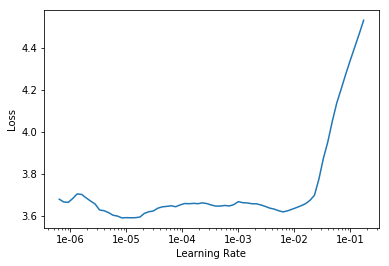

In [26]:
learner.recorder.plot(skip_end=15)

In [22]:
# define non-default momentums
moms=(0.8,0.7)

In [23]:
learner.fit_one_cycle(4, 1e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,3.650695,3.406265,0.428821
2,3.780002,3.396528,0.429244
3,3.829076,3.364912,0.435912
4,3.584365,3.340251,0.439377


In [24]:
# save model
learner.save('ru-100-unk-best')

In [ ]:
# cell to restart notebook kernel from within
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

### Fine tune on ruSentEval Unsupervised data

http://study.mokoron.com/ - I get sample data from ~17M tweets database

In [7]:
# path for ruSentiment data
rusent_data_path = Path('data/ruSentiment/')

In [8]:
bs = 48

In [9]:
rusent_data_path.ls()

[PosixPath('data/ruSentiment/merg_rusenteval_rusent.csv'),
 PosixPath('data/ruSentiment/models'),
 PosixPath('data/ruSentiment/unsup_sample.csv'),
 PosixPath('data/ruSentiment/tmp_clas'),
 PosixPath('data/ruSentiment/tmp_lm'),
 PosixPath('data/ruSentiment/rusentiment_random_posts.csv'),
 PosixPath('data/ruSentiment/unsup-no-null.csv'),
 PosixPath('data/ruSentiment/rusentiment_test.csv'),
 PosixPath('data/ruSentiment/rusentiment_preselected_posts.csv')]

In [10]:
# create LM DataBunch from ruSentEval unsupervised corpus of tweets sample (http://study.mokoron.com/)
data1_lm = TextLMDataBunch.from_csv(rusent_data_path, 'unsup_sample.csv', text_cols=0,
                                    valid_pct=0.1, bs=bs)

In [11]:
itos, stoi, data_path = data1_lm.vocab.itos, data1_lm.vocab.stoi, data1_lm.path
print('Size of vocabulary:', len(itos))
print('First 20 words in vocab:', itos[:20])
print(str(data_path))

Size of vocabulary: 60003
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '/', ':', ',', 'http', 't.co', '.', 'в', '#', 'rt', 'и', 'не', '-']
data/ruSentiment


In [12]:
(data1_lm.path).ls()

[PosixPath('data/ruSentiment/merg_rusenteval_rusent.csv'),
 PosixPath('data/ruSentiment/train'),
 PosixPath('data/ruSentiment/valid'),
 PosixPath('data/ruSentiment/models'),
 PosixPath('data/ruSentiment/unsup_sample.csv'),
 PosixPath('data/ruSentiment/tmp_clas'),
 PosixPath('data/ruSentiment/tmp_lm'),
 PosixPath('data/ruSentiment/rusentiment_random_posts.csv'),
 PosixPath('data/ruSentiment/unsup-no-null.csv'),
 PosixPath('data/ruSentiment/rusentiment_test.csv'),
 PosixPath('data/ruSentiment/rusentiment_preselected_posts.csv')]

In [13]:
len(data1_lm.train_ds), len(data1_lm.valid_ds)

(1799487, 199944)

In [10]:
data1_lm.show_batch()

idx,text
0,"xxbos xxmaj страны - члены xxup вто договорились о реформе организации xxbos xxmaj всегда говорю , что нормально все будет и никто не умрет xxbos чай , таблетки , теплые носки и шарф \n опять простуда ( ( xxbos сын зашел к матери а у матери упало полотенце видео http : / / t.co / xxunk xxbos xxmaj скажите вслух не xxunk - xxmaj миша , xxmaj xxunk , медведь"
1,"xxmaj марьино для моряков xxbos xxmaj снукер - xxmaj чемпионат xxmaj британии - xxmaj трое в пути . xxmaj чемпионат xxmaj британии & … xxbos xxmaj хахаха http : / / t.co / xxunk xxbos xxmaj не совсем понимаю зачем вы смотрите этот xxunk престарелых пидарасов , ребята . # xxunk xxbos отличие 8 часов . xxmaj так что в 18.00 по белорусскому времени должен быть"
2,"с ним , \n xxmaj чтоб каждый увидел и понял суть : \n xxmaj успей любить . xxmaj годы не вернуть , время не вернуть ♥ xxbos xxunk no \n xxunk лицо группы xdd xxbos xxmaj можно ли завоевать свободу при помощи насилия ? xxbos xxmaj глава xxmaj московской xxmaj хельсинкской группы рассказала lifenews о своих впечатлениях от неожиданной встречи с xxunk xxmaj администрации ... xxbos xxup rt @no_4_u :"
3,- http : / / t.co / xxunk xxbos xxup rt @olka_luchik : xxunk вкуснятина * о * спасибо:3 xxbos этот тупой апрель все лезет к нам обоим в душу xxbos http : / / t.co / xxunk как приготовить зеленый кофе с имбирем для похудения в домашних условиях xxbos xxup rt xxunk : # хочупровестиновогоднююночьвместес xxunk http : / / t.co / xxunk xxbos xxup rt xxunk : xxmaj
4,"твит # mtvstars xxmaj one xxmaj direction http : / / t.co / xxunk m xxbos xxmaj снукер - xxmaj чемпионат xxmaj британии - xxmaj кто же первый на турнире и в рейтинге ? xxbos xxmaj это был xxmaj xxunk xxmaj xxunk , рыцарь кисти , аналитик , xxunk , философ , гражданин и член . xxmaj элиты , в смысле . xxbos грубо . \n"


In [16]:
data1_lm.train_ds[0]

(Text xxbos xxup rt xxunk : в xxunk дверь , xxunk на пороге , xxunk xxunk походкой xxunk и xxunk .,
 Category 0)

In [17]:
# save data bunch 
data1_lm.save('tmp_lm')

In [10]:
data1_lm = TextLMDataBunch.load(rusent_data_path, 'tmp_lm', bs=bs)

#### Create Learner and Finetune model from pretrained fnames

In [11]:
# pretrained model and vocab from first step of training LM
pretrained_fnames = ['ru-100-unk-best', 'itos']

In [12]:
# create learner and provide pretrained files to finetune wiki-LM with ruSentiment data
learner = language_model_learner(data1_lm, pretrained_fnames=pretrained_fnames, drop_mult=1.0)

Unknown tokens 32987, first 100: ['t.co', 'rt', '"', 'mtvstars', 'seconds', 'direction', 'гдз', ':)', '\xa0', ':d', 'gameinsight', '\n\n', ':3', 'решебник', 'androidgames', 'шлюхи', 'имбирем', 'блять', 'блин', 'бля', 'justin', 'bieber', 'ахах', 'ненавижу', 'пойду', 'ахаха', '©', '@youtube', 'євромайдан', 'массаж', 'пиздец', 'твит', '️', 'хд', 'ipadgames', 'сижу', 'похудения', 'сука', 'твиттер', ':(', 'ладно', 'смотрю', 'евромайдан', 'ахахах', 'андроид', '\n\n ', 'жду', ';)', 'нахуй', 'лол', 'урока', 'торрент', 'конспект', '\xa0 ', '❤', 'обожаю', 'прям', 'хочупровестиновогоднююночьвместес', 'бесит', 'болит', ':-)', 'майдан', 'щас', 'дp', '4о', 'o5', 'о5', '^^', 'ретвит', 'ищу', '4o', 'бл', '♥', 'фгос', '11.12.13', 'проверь', '@koffboy', 'боюсь', 'ох', 'скучаю', 'жуйк', 'майдане', 'грядки', '@5umm', 'чувак', 'ответами', 'радует', ':*', 'любишь', 'тви', 'делаю', 'янукович', 'интим', 'ахахаха', 'реферат', '<3', 'говно', 'лень', 'iphonegames', 'хуй']


In [13]:
learner.callback_fns += [partial(CSVLogger, filename=f"{learner.model_dir}/lm-history"),
                         partial(SaveModelCallback, every='epoch', name='lm')]

In [14]:
learner.callback_fns

[fastai.basic_train.Recorder,
 functools.partial(<class 'fastai.callbacks.csv_logger.CSVLogger'>, filename='models/lm-history'),
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, every='epoch', name='lm')]

In [15]:
learner.opt_func = partial(optim.Adam, betas=(0.8, 0.99))

In [16]:
learner.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.8, 0.99))

In [17]:
learner.true_wd

True

In [18]:
learner.metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.LongTensor) -> <function NewType.<locals>.new_type at 0x7fa75f4e4f28>>]

In [18]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


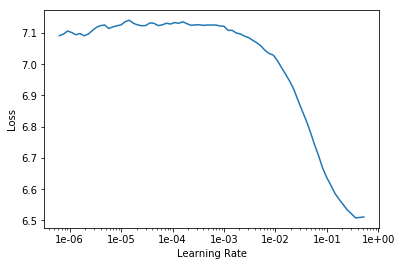

In [19]:
learner.recorder.plot(skip_end=15)

In [19]:
moms = (0.8, 0.7)

In [21]:
# learning the same way as in fastai v1 examples
learner.fit_one_cycle(1, 2e-2, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,4.199973,3.885408,0.395484


In [22]:
learner.save('fit_head')

In [23]:
learner.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (1799487 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/ruSentiment
x: LMTextList (1799487 items)
[Text xxbos xxup rt xxunk : в xxunk дверь , xxunk на пороге , xxunk xxunk походкой xxunk и xxunk ., Text xxbos xxmaj смерть стучится ко всем одинаково ., Text xxbos xxunk похоже ты xxunk :), Text xxbos xxmaj мужчина должен найти правильную цель в жизни , а женщина — мужчину с правильной целью . xxunk xxmaj шоу, Text xxbos xxup rt @dany_belik : xxmaj шизофрения - это удобно . xxmaj всегда есть с кем xxunk]...
Path: data/ruSentiment;

Valid: LabelList
y: LMLabel (199944 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/ruSentiment
x: LMTextList (199944 items)
[Text xxbos xxunk да, Text xxbos @nashka_ya ну ок , я ща выхожу ток, Text xxbos xxup rt xxunk : xxmaj хера я такой ленивый ☺ ️, Text xxbos xxunk не гордиться невозможно ) и все же у меня есть надежда , чт

In [24]:
learner.unfreeze()

In [25]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


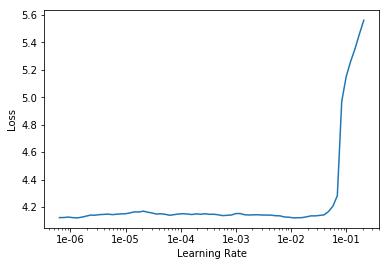

In [26]:
learner.recorder.plot(skip_end=15)

In [27]:
learner.fit_one_cycle(10, 1e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,3.735216,3.585653,0.424639
2,3.587598,3.429011,0.444064
3,3.509658,3.332727,0.457225
4,3.427868,3.272593,0.464458
5,3.369173,3.226294,0.470309
6,3.315650,3.187328,0.474733
7,3.284205,3.163924,0.477787
8,3.273819,3.146281,0.480194
9,3.245285,3.137547,0.481321
10,3.226189,3.135052,0.481679


In [28]:
# save fine_tuned model
learner.save('fine_tuned')

In [29]:
# save finetuned models encoder to use for classification task
learner.save_encoder('fine_tuned_enc')

In [20]:
learner.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (1799487 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/ruSentiment
x: LMTextList (1799487 items)
[Text xxbos xxup rt xxunk : в xxunk дверь , xxunk на пороге , xxunk xxunk походкой xxunk и xxunk ., Text xxbos xxmaj смерть стучится ко всем одинаково ., Text xxbos xxunk похоже ты xxunk :), Text xxbos xxmaj мужчина должен найти правильную цель в жизни , а женщина — мужчину с правильной целью . xxunk xxmaj шоу, Text xxbos xxup rt @dany_belik : xxmaj шизофрения - это удобно . xxmaj всегда есть с кем xxunk]...
Path: data/ruSentiment;

Valid: LabelList
y: LMLabel (199944 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/ruSentiment
x: LMTextList (199944 items)
[Text xxbos xxunk да, Text xxbos @nashka_ya ну ок , я ща выхожу ток, Text xxbos xxup rt xxunk : xxmaj хера я такой ленивый ☺ ️, Text xxbos xxunk не гордиться невозможно ) и все же у меня есть надежда , чт

In [21]:
learner.unfreeze()

In [22]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


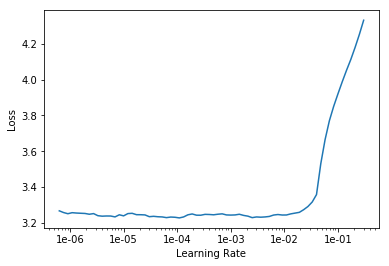

In [23]:
learner.recorder.plot(skip_end=15)

In [24]:
# trying 10 more iterations to fintune
learner.fit_one_cycle(10, 1e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,3.231057,3.140359,0.481063
2,3.269537,3.151430,0.479394
3,3.294204,3.152580,0.478704
4,3.283042,3.139181,0.480054
5,3.252020,3.123043,0.482185
6,3.229360,3.104628,0.484357
7,3.189149,3.088255,0.486624
8,3.189629,3.076576,0.488203
9,3.175652,3.069256,0.489264
10,3.124987,3.067669,0.489498


In [25]:
# save fine_tuned model
learner.save('fine_tuned')

In [26]:
# save finetuned models encoder to use for classification task
learner.save_encoder('fine_tuned_enc')

In [ ]:
# cell to restart notebook kernel from within
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [27]:
# check text generation with LM
TEXT = "сегодня утром я"
N_WORDS = 10
N_SENTENCES = 2

In [28]:
print("\n".join(learner.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

сегодня утром я пороки росомаха снимаю зафиксировали финляндию истинного посадит @homutoov вредно открываются
сегодня утром я декабр финансовых кеша фрагмент интимдосуг славе паразит растущие рода @sweetmolko


### Classifier

Here we are working on ruSentiment classification task from http://text-machine.cs.uml.edu/projects/rusentiment/

In [11]:
rusent_data_path.ls()

[PosixPath('data/ruSentiment/merg_rusenteval_rusent.csv'),
 PosixPath('data/ruSentiment/models'),
 PosixPath('data/ruSentiment/unsup_sample.csv'),
 PosixPath('data/ruSentiment/tmp_clas'),
 PosixPath('data/ruSentiment/tmp_lm'),
 PosixPath('data/ruSentiment/rusentiment_random_posts.csv'),
 PosixPath('data/ruSentiment/unsup-no-null.csv'),
 PosixPath('data/ruSentiment/rusentiment_test.csv'),
 PosixPath('data/ruSentiment/rusentiment_preselected_posts.csv')]

In [12]:
rand = pd.read_csv(rusent_data_path/'rusentiment_random_posts.csv')
presel = pd.read_csv(rusent_data_path/'rusentiment_preselected_posts.csv')

In [13]:
# create classification databunch, please note usage of LM vocab
# as a train data we use both random posts and preselected posts
# and testset to mesure quality of classifier
data_clas = TextClasDataBunch.from_df(path=rusent_data_path,
                                      train_df=pd.concat([rand, presel], ignore_index=True),
                                      valid_df=pd.read_csv(rusent_data_path/'rusentiment_test.csv'),
                                      vocab=data1_lm.vocab, text_cols='text', label_cols='label', bs=bs)

In [14]:
data_clas.show_batch()

text,target
"xxbos - xxmaj отдать тебе любовь ? \n - xxmaj отдай . \n - xxmaj она в грязи . \n - xxmaj отдай в грязи . \n - я xxunk хочу . \n - xxmaj гадай \n - xxmaj еще спросить хочу . \n - xxmaj спроси . \n - xxmaj допустим , xxunk . \n - xxmaj xxunk . \n - xxmaj допустим , позову . \n - xxmaj",neutral
xxbos xxmaj xxunk прошлое в огне … xxmaj гори все \n xxunk … \n xxmaj не xxunk ни о чем … xxmaj забудьте \n xxunk ! \n xxmaj не вспоминайте о плохом … и о \n хорошем … \n xxmaj не собирайте под столом … от \n счастья xxunk … \n xxmaj ведь вы достойны не кусков … и не \n xxunk … \n xxmaj лишь стоит руку протянуть …,neutral
"xxbos xxmaj xxunk : \n я люблю свою работу , \n я приду сюда в субботу \n и конечно в воскресенье . \n xxmaj здесь я встречу день рожденье , \n xxmaj новый год , 8 xxmaj марта , \n xxmaj ночевать здесь буду завтра ! \n xxmaj если я не заболею , \n xxmaj не сорвусь , не xxunk , \n xxmaj здесь я встречу все рассветы , \n",neutral
xxbos - xxmaj привет . \n - xxmaj ага \n - xxmaj ты что делаешь ? \n - xxmaj по комнате бегаю . \n - xxmaj почему ? \n - xxmaj потому что соседи твои идиоты . \n - xxmaj причём тут соседи ? \n - xxmaj потому что они краску не любят . \n - xxmaj какую краску ? \n - xxmaj видимо xxunk . \n - xxmaj как,skip
"xxbos xxmaj друг - это … . xxmaj тот , который узнает тебя издалека и при виде твоего xxunk xxunk уже xxunk в улыбке … . xxunk xxmaj друг - тот , который хочет быть с тобой , когда тебе трудно … . и хочет , чтобы ты был с ним , когда ему хорошо … . xxunk xxmaj лучший друг - это тот , с которым ты можешь сидеть",neutral


In [15]:
# number of classes
data_clas.train_ds.c

5

In [16]:
# classes labels
data_clas.train_ds.classes

['negative', 'neutral', 'positive', 'skip', 'speech']

In [17]:
data_clas

TextClasDataBunch;

Train: LabelList
y: CategoryList (28218 items)
[Category negative, Category speech, Category skip, Category negative, Category skip]...
Path: data/ruSentiment
x: TextList (28218 items)
[Text xxbos а попа xxunk давно , что ты с кавказа .. перестану общаться с тобой, Text xxbos з прошедшим xxmaj днем xxmaj ангела xxrep 8 ), Text xxbos xxmaj два дня до xxunk с острова xxrep 7 !, Text xxbos xxmaj блин , почему эта жизнь столь не справедлива xxrep 4 (, Text xxbos где еще встречать свой день рождения как не на кладбище xxrep 4 )]...
Path: data/ruSentiment;

Valid: LabelList
y: CategoryList (2967 items)
[Category neutral, Category positive, Category neutral, Category skip, Category speech]...
Path: data/ruSentiment
x: TextList (2967 items)
[Text xxbos xxmaj александр , тебе к лицу эта пушка :) 
, Text xxbos xxmaj скоро ты вернешься домой , грязный , не xxunk но такой любимый ❤, Text xxbos xxunk ... ) ), Text xxbos xxmaj мы просто с [ xxunk ] xxunk xxrep 5 ) 
 к новому году

In [18]:
len(data_clas.vocab.itos)

60003

In [19]:
data_clas.batch_size

24

In [20]:
# save for future use
data_clas.save('tmp_clas')

In [10]:
data_clas = TextClasDataBunch.load(rusent_data_path, 'tmp_clas', bs=bs)

#### Training

In [21]:
# create learner and train
# train classifier as in fastai imdb example
learner = text_classifier_learner(data=data_clas, drop_mult=0.5)

In [22]:
# load fine tuned encoder
learner.load_encoder('fine_tuned_enc')

In [23]:
learner.callback_fns += [partial(SaveModelCallback, every='epoch', name='cls')]

In [24]:
learner.freeze()

In [25]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


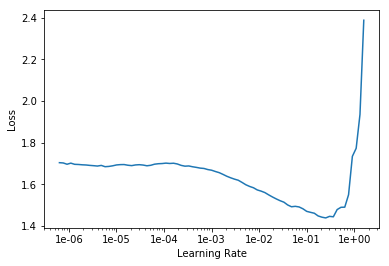

In [26]:
learner.recorder.plot()

In [27]:
moms=(0.8,0.7)

In [28]:
learner.fit_one_cycle(1, 2e-2, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,1.058190,0.838331,0.664644


In [29]:
learner.save('first')

In [14]:
learner.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (21268 items)
[Category negative, Category speech, Category skip, Category negative, Category skip]...
Path: .
x: TextList (21268 items)
[Text xxbos а попа подозревала давно , что ты с кавказа .. перестану общаться с тобой, Text xxbos з прошедшим xxmaj днем xxmaj ангела xxrep 8 ), Text xxbos xxmaj два дня до xxunk с острова xxrep 7 !, Text xxbos xxmaj блин , почему эта жизнь столь не справедлива xxrep 4 (, Text xxbos где еще встречать свой день рождения как не на кладбище xxrep 4 )]...
Path: data/ruSentiment;

Valid: LabelList
y: CategoryList (2967 items)
[Category neutral, Category positive, Category neutral, Category skip, Category speech]...
Path: .
x: TextList (2967 items)
[Text xxbos xxmaj александр , тебе к лицу эта пушка :) 
, Text xxbos xxmaj скоро ты вернешься домой , грязный , не xxunk но такой любимый ❤, Text xxbos помниш ... ) ), Text xxbos xxmaj мы просто с [ xxunk ] xxunk xxrep 5 ) 
 к новому году в xxun

In [30]:
learner.freeze_to(-2)

In [31]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


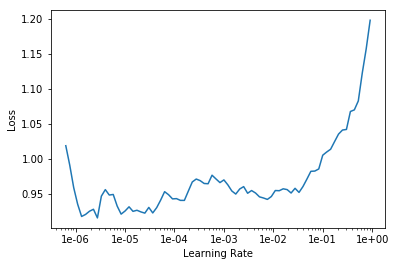

In [32]:
learner.recorder.plot()

In [33]:
learner.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.924162,0.778857,0.697337


In [34]:
learner.save('second')

In [36]:
learner.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (21268 items)
[Category negative, Category speech, Category skip, Category negative, Category skip]...
Path: .
x: TextList (21268 items)
[Text xxbos а попа подозревала давно , что ты с кавказа .. перестану общаться с тобой, Text xxbos з прошедшим xxmaj днем xxmaj ангела xxrep 8 ), Text xxbos xxmaj два дня до xxunk с острова xxrep 7 !, Text xxbos xxmaj блин , почему эта жизнь столь не справедлива xxrep 4 (, Text xxbos где еще встречать свой день рождения как не на кладбище xxrep 4 )]...
Path: data/ruSentiment;

Valid: LabelList
y: CategoryList (2967 items)
[Category neutral, Category positive, Category neutral, Category skip, Category speech]...
Path: .
x: TextList (2967 items)
[Text xxbos xxmaj александр , тебе к лицу эта пушка :) 
, Text xxbos xxmaj скоро ты вернешься домой , грязный , не xxunk но такой любимый ❤, Text xxbos помниш ... ) ), Text xxbos xxmaj мы просто с [ xxunk ] xxunk xxrep 5 ) 
 к новому году в xxun

In [35]:
learner.freeze_to(-3)

In [36]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


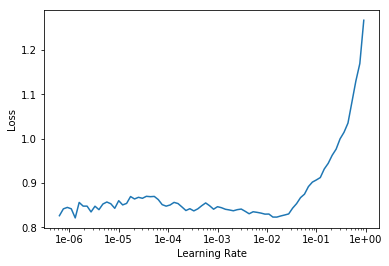

In [37]:
learner.recorder.plot()

In [38]:
learner.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.819542,0.728567,0.721267


In [39]:
learner.save('third')

In [40]:
learner.unfreeze()

In [41]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


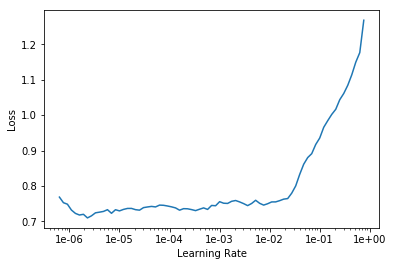

In [42]:
learner.recorder.plot()

In [43]:
learner.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.735982,0.717970,0.720256
2,0.691754,0.706860,0.725312


In [45]:
learner.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.668335,0.728310,0.716212
2,0.611837,0.708961,0.729693


In [46]:
learner.save('best-classifier')

In [114]:
learner.load('best-classifier')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (28218 items)
[Category negative, Category speech, Category skip, Category negative, Category skip]...
Path: data/ruSentiment
x: TextList (28218 items)
[Text xxbos а попа xxunk давно , что ты с кавказа .. перестану общаться с тобой, Text xxbos з прошедшим xxmaj днем xxmaj ангела xxrep 8 ), Text xxbos xxmaj два дня до xxunk с острова xxrep 7 !, Text xxbos xxmaj блин , почему эта жизнь столь не справедлива xxrep 4 (, Text xxbos где еще встречать свой день рождения как не на кладбище xxrep 4 )]...
Path: data/ruSentiment;

Valid: LabelList
y: CategoryList (2967 items)
[Category neutral, Category positive, Category neutral, Category skip, Category speech]...
Path: data/ruSentiment
x: TextList (2967 items)
[Text xxbos xxmaj александр , тебе к лицу эта пушка :) 
, Text xxbos xxmaj скоро ты вернешься домой , грязный , не xxunk но такой любимый ❤, Text xxbos xxunk ... ) ), Text xxbos xxmaj мы просто с [ xxunk ] xxunk xxrep 5 )

In [47]:
# sanity check for accuracy, precision, recall and f1-score
preds, targets = learner.get_preds()

In [48]:
targets.unique()

tensor([4, 0, 2, 3, 1])

In [49]:
pred_classes = torch.argmax(preds, dim=1)

In [50]:
np.set_printoptions(precision=3)

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

In [53]:
print(classification_report(targets, pred_classes, 
                            target_names=data_clas.train_ds.classes, digits=4))

              precision    recall  f1-score   support

    negative     0.5871    0.6008    0.5939       258
     neutral     0.8018    0.7606    0.7806      1420
    positive     0.6252    0.7034    0.6620       536
        skip     0.5110    0.4682    0.4887       346
      speech     0.8968    0.9607    0.9276       407

   micro avg     0.7297    0.7297    0.7297      2967
   macro avg     0.6844    0.6987    0.6906      2967
weighted avg     0.7303    0.7297    0.7291      2967



In [54]:
# check prediction for one example
learner.predict('сомнительная перспектива')

(Category neutral,
 tensor(1),
 tensor([6.0323e-02, 5.8972e-01, 2.2328e-01, 1.2659e-01, 8.7127e-05]))

In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 155   68   15   19    1]
 [  74 1080  160   93   13]
 [  11   88  377   39   21]
 [  24  105   45  162   10]
 [   0    6    6    4  391]]
Normalized confusion matrix
[[0.601 0.264 0.058 0.074 0.004]
 [0.052 0.761 0.113 0.065 0.009]
 [0.021 0.164 0.703 0.073 0.039]
 [0.069 0.303 0.13  0.468 0.029]
 [0.    0.015 0.015 0.01  0.961]]


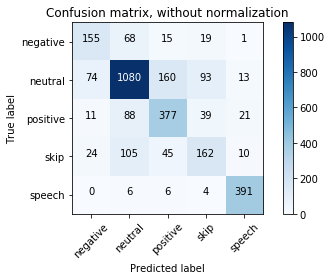

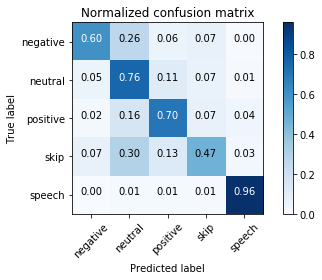

In [56]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(targets, pred_classes)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=data_clas.train_ds.classes,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=data_clas.train_ds.classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()